# NYPD Civilian Complaints


In [9]:
allegations=pd.read_csv("allegations.csv")

allegations.columns

Index(['unique_mos_id', 'first_name', 'last_name', 'command_now', 'shield_no',
       'complaint_id', 'month_received', 'year_received', 'month_closed',
       'year_closed', 'command_at_incident', 'rank_abbrev_incident',
       'rank_abbrev_now', 'rank_now', 'rank_incident', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'outcome_description',
       'board_disposition'],
      dtype='object')

# Summary of Findings

### Introduction
This dataset records each complaint in relation to the officer's background, complainant's background, as well as contents of the complaint and final result. Within the dataset, I would like to inspect how does the complainant's background relates to the treatment/complaint they confront as well as if biases exists within nypd, possibly abusing their power toward minority groups. 

### Cleaning and EDA
- make precinct,shield no., complainant_id,unique_mos_id a string(it's a label not quantitative value)
- add column age_diff to calculate difference of age between officer and complainant
- add column duration to calculate the duration it takes to resolve the case
- add column result to categorize the result into substantiated, unsubstantiated, or exonerated


### Assessment of Missingness
- The ethnicity of the complainant might be NMAR because some people might discriminate against ethnicity/race, adn therefore making the case unsubstantiated. Therefore, people who chose not to answer(null values) are more likeley to be minority groups. In other words, the missingness of those values does affect the analysis and represents some essential information.
- When evaluating the complainant_ethnicity against other columns, it is MAR on age_diff, duration, month_closed, year_closed, year_received. In other words, the missingness of complainant_ethnicity is dependent on age_diff, duration, month_closed, year_closed, and year_received. After inspecting this property, we'll further on our testing in identifying whether complainant_ethnicity actually affects the proportion of having case resolved as substantiated. 

### Hypothesis Test
We perform hypothesis testing, answering the question of whether substantiated ratio is the same across complainant_ethnicity. The null hypothesis and alternative hypothesis descriptions are described below(at the corresponding bloc). The result we acquire is that, given p_value<0.01, we claim that the substantiated ratio across complainant_ethnicity is indeed different, possibly suggesting certain biases during judgement. Yet, this is only our guess behind this phenomenon. Hypothesis testing only shows this phenomenon, providing no clues about the actual reason behind it. 

# Code

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA

In [10]:
# make precinct a string, because precinct is a label for a certain area, rather than numerical value that can be evaluated
allegations["precinct"]=allegations["precinct"].astype(str)

# make shield number as string(because it's a label instead of quantitative,comparable data)
# replace 0 wilth np.NaN because there's 5392 person with shield number 0, and most likely those people didn't have shield number recorded
allegations["shield_no"]=allegations["shield_no"].replace(0, np.NaN)
allegations["complainant_ethnicity"]=allegations["complainant_ethnicity"].replace("Unknown", np.NaN)
allegations["shield_no"]=allegations["shield_no"].astype(str)

# make complaint_id a string(nominal, not quantitative)
allegations["complaint_id"]=allegations["complaint_id"].astype(str)

#make unique_mos_id a string(nominal, not quantitative)
allegations["unique_mos_id"]=allegations["unique_mos_id"].astype(str)

#Complainant age should be greater than 0, fill invalid values with np.NaN
allegations.loc[allegations["complainant_age_incident"]<=0, "complainant_age_incident"]=np.NaN

#Create column duration(in months) that calculates the amount of time it takes to resolve a case
allegations["duration"]=12*(allegations["year_closed"]-allegations["year_received"])+(allegations["month_closed"]-allegations["month_received"])
#Create column age_diff that calculates difference between officer age and complainant age
allegations["age_diff"]=allegations["mos_age_incident"]-allegations["complainant_age_incident"]
#Create column result that categorizes the board disposition as either unsubstantiated, exonerated, or substantiated
allegations["result"]=allegations["board_disposition"].copy()
allegations["result"]=allegations["result"].apply(lambda x: "Substantiated" if x.split(" ")[0]=="Substantiated" else x)

allegations["complainant_ethnicity"].value_counts()
allegations.to_csv("cleaned_allegations.csv")


<AxesSubplot:>

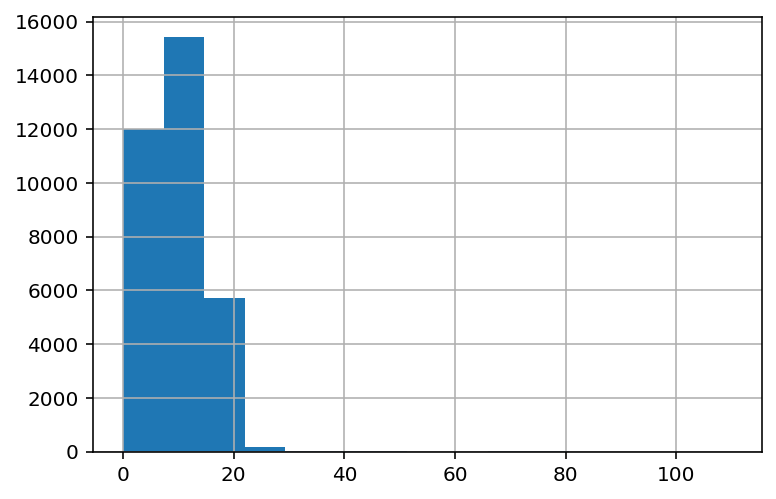

In [110]:
#Most cases are resolved within two years (75% are resolved almost within one year based on descriptive stats)
#Duration is skewed to the right, with max value = 110 months = 9 years
allegations["duration"].hist(bins=15)

<AxesSubplot:>

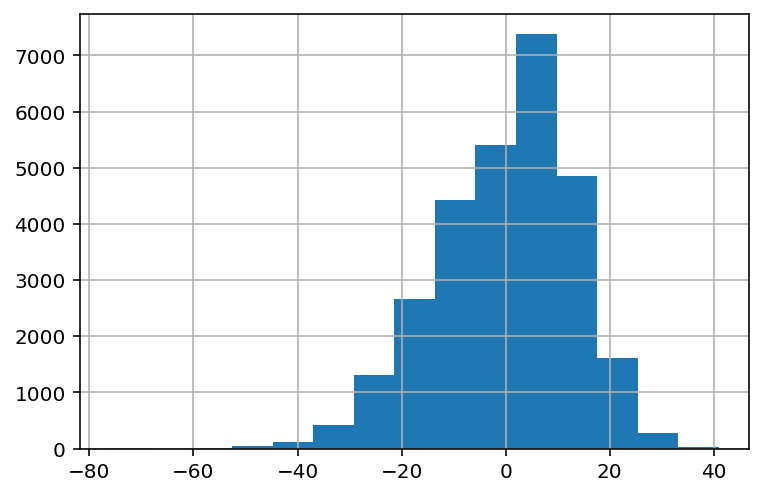

In [117]:
#Age_diff is slightly skewed to the left, meaning that in general, officer age is slightly larger than complainant age
allegations["age_diff"].hist(bins=15)

<AxesSubplot:>

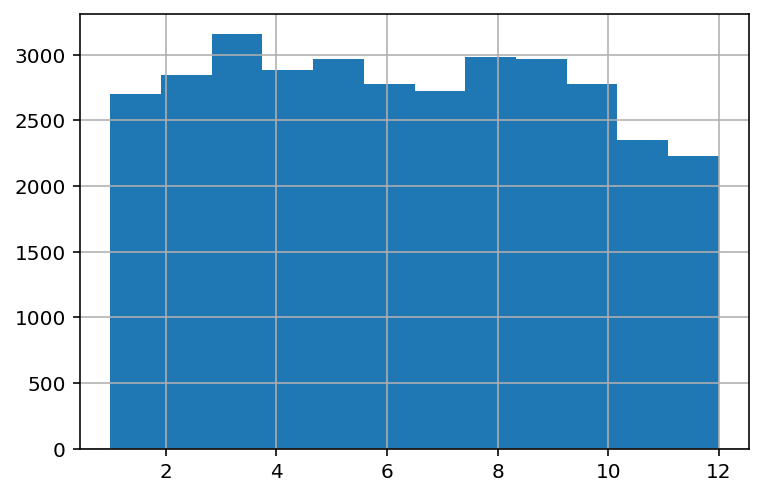

In [220]:
allegations["month_received"].hist(bins=12)

Explore the number of cases being reported each month
At first glanace, looks uniform(except November and December), more exploration required(in hypothesis testing)

complainant_gender
Female                    4442
Gender non-conforming        2
Male                     20419
Not described               33
Transman (FTM)               5
Transwoman (MTF)            20
dtype: int64

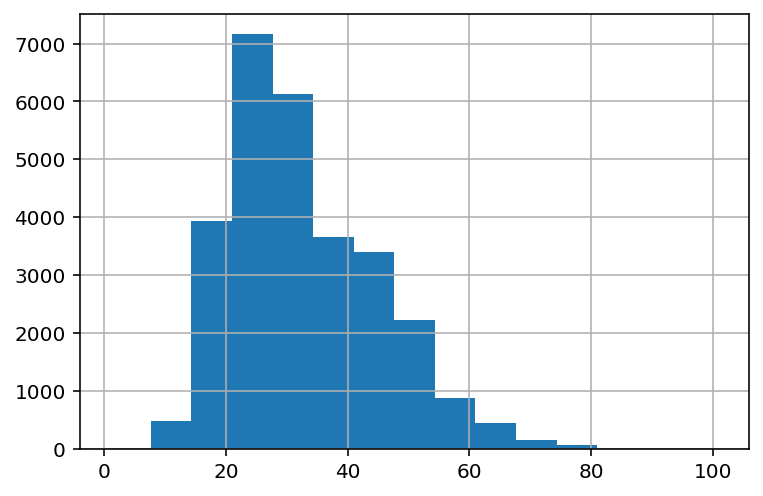

In [129]:
allegations["complainant_age_incident"].hist(bins=15)
allegations[(allegations["complainant_age_incident"]>=20) & (allegations["complainant_age_incident"]>=20)].groupby("complainant_gender").size()


Most complainant are reported by people within ages 20-40. I am later going to inspect how the cases vary by gender within this majority age group





complainant_gender
Female    AxesSubplot(0.672059,0.125;0.227941x0.755)
Male      AxesSubplot(0.672059,0.125;0.227941x0.755)
Name: duration, dtype: object

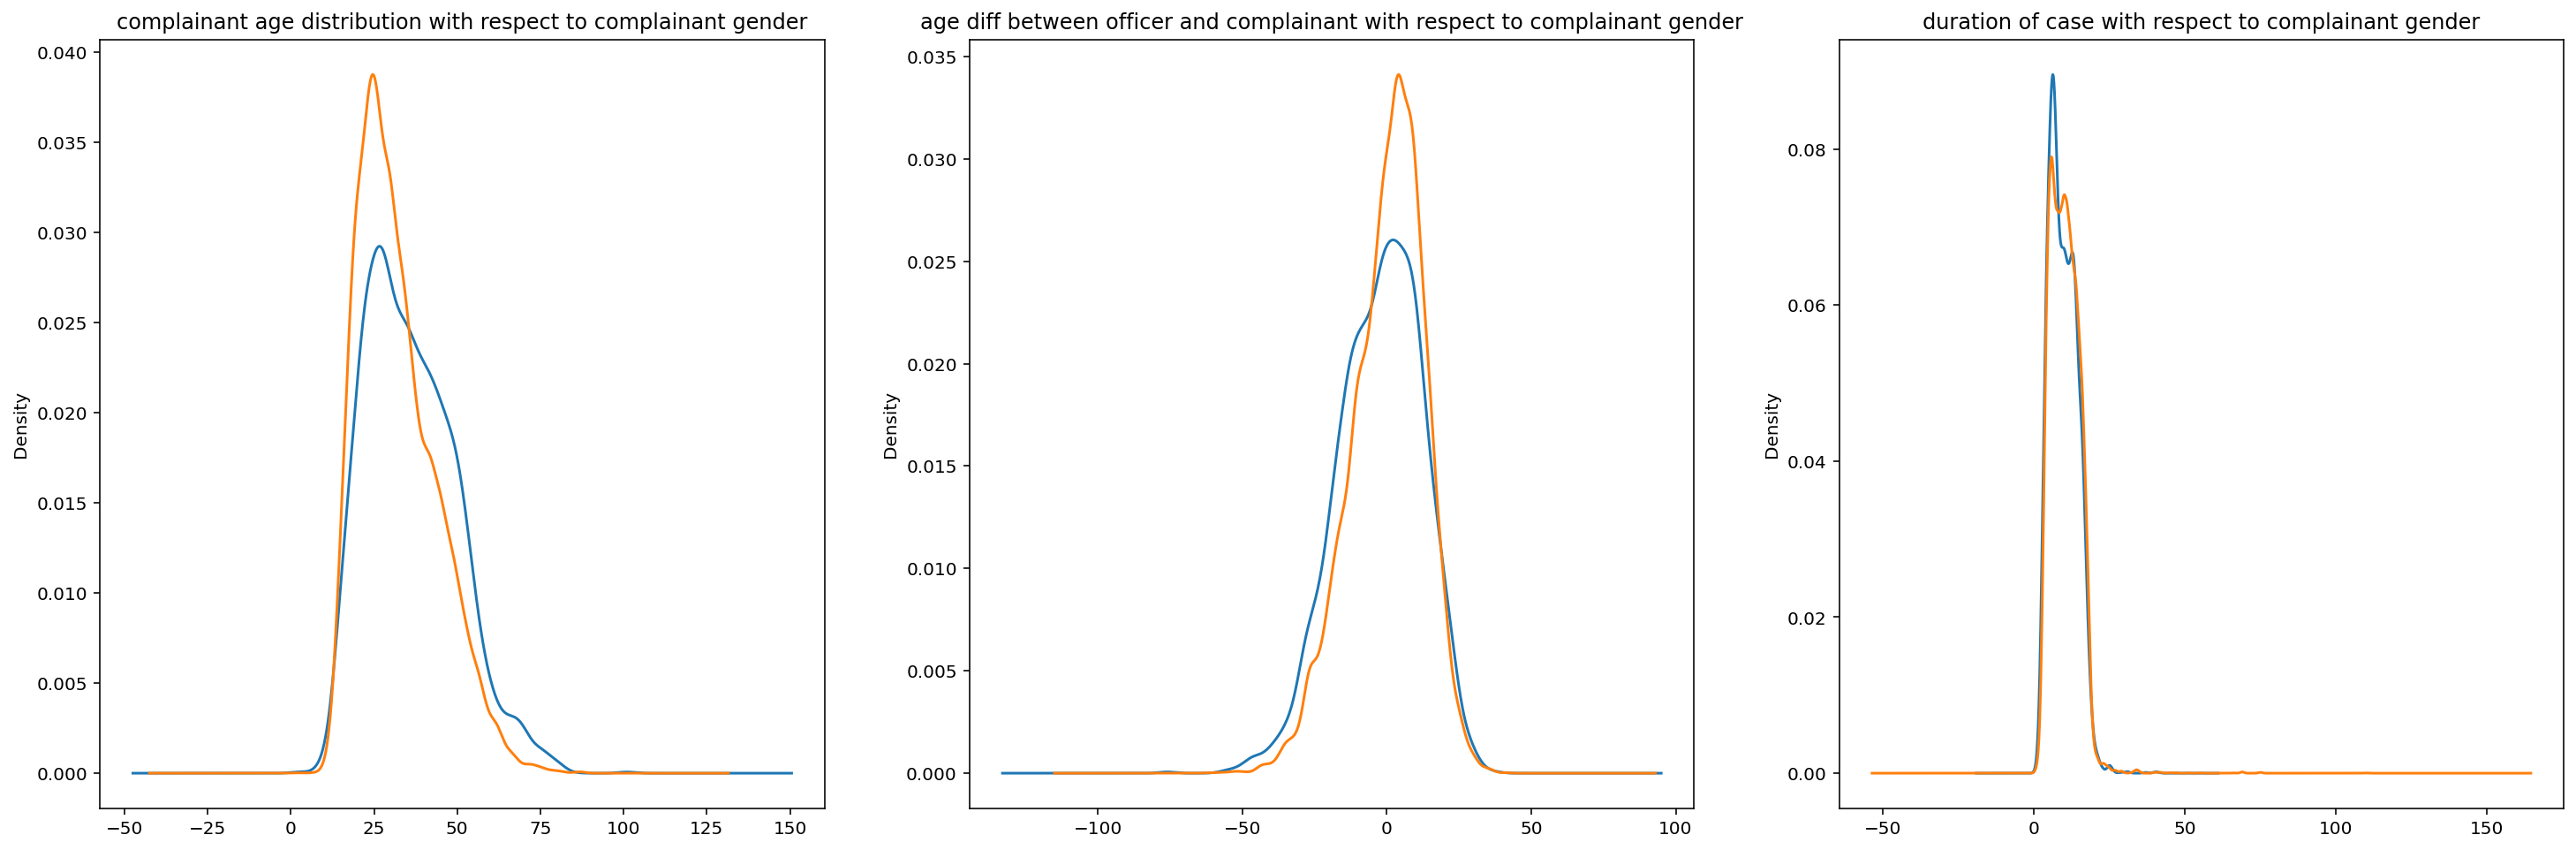

In [183]:
#Interesting Fact: Within this age group, the number of males are significantly more than females reporting the complainant
#24058(male vs.5021)
p_table=allegations.pivot_table(index="complainant_gender", columns="result", aggfunc='size', values="complaint_id")
p_table=p_table.div(p_table.sum(axis=1), axis=0).fillna(0)
#I originally thought that possible gender discimination might occur, yet when looking upon the substantiated ratio, male and female have 5% diff
#Hypothesis testing required to truly determine if the distributions are the same
p_table
#allegations.groupby(["complainant_gender", "result"])["complainant_age_incident"].count()
fig, axes = plt.subplots(1,3, figsize=(25,8))
is_male_female=(allegations["complainant_gender"]=="Male") | (allegations["complainant_gender"]=="Female")
allegations[is_male_female].groupby("complainant_gender")["complainant_age_incident"].plot(kind="kde", title="complainant age distribution with respect to complainant gender", ax=axes[0])
allegations[is_male_female].groupby("complainant_gender")["age_diff"].plot(kind="kde",ax=axes[1], title="age diff between officer and complainant with respect to complainant gender")
allegations[is_male_female].groupby("complainant_gender")["duration"].plot(kind="kde",ax=axes[2], title="duration of case with respect to complainant gender")

Within this age group, the number of males are significantly more than females reporting the complainant
24058(male vs.5021). I originally thought that possible gender discimination might occur, yet when looking upon the substantiated ratio, male and female have 5% diff. Hypothesis testing required to truly determine if the distributions are the same. The values for gender non-conforming, not described, transman, transwoman have different ratios because of their small sample sizes relative to male and female. Interestingly enough, when plotting a kde, the distribution of ages between males and females doesn't really look that different, which is out of my expectation in terms of extremeness, as I originally thought age might play an essential role with number of reported cases. (Younger female might be less experienced and possibly more vulnerable to police abuse of authority). A KS-stats is needed to verify.When plotting a kde for a distribution, grouped by male/female, of age difference between police officer and complainant, the distribution doesn't look exactly the same either. KS stats is needed to investigate whether we are confident enough to state that the distributions by gender(consider only male and female in this case) are different. Last but not least, I was thinking that the duration of the case would be dependent on gender, yet the plot is nearly the same, except the trivial differences in peaks. Since this is an EDA process, plots are generated, yet the validity of my hypothesis are verified in hypothesis testing.

In [190]:
p_table=allegations.pivot_table(index="complainant_gender", columns="fado_type", values="complaint_id",aggfunc="size")
p_table=p_table.div(p_table.sum(axis=1), axis=0).fillna(0)
p_table

fado_type,Abuse of Authority,Discourtesy,Force,Offensive Language
complainant_gender,,,,
Female,0.546505,0.202748,0.208325,0.042422
Gender non-conforming,1.000000,0.000000,0.000000,0.000000
Male,0.607116,0.134217,0.240502,0.018164
Not described,0.649123,0.175439,0.122807,0.052632
Transman (FTM),0.200000,0.400000,0.200000,0.200000
Transwoman (MTF),0.700000,0.100000,0.050000,0.150000


The category of complaint(fado_type) might be different based on gender from intuition, because men and women usually face different kinds of abuse. From this pivot table, it can be seen that males,comparing to females, encounter more brutal force and abuse of authority, while women encountered more discourtesy and offensive language. It is explainable by the social expectations and masculinity involved within the society, but we can't be definite about the factors that contribute to this result. 

In [237]:
p_table=allegations.pivot_table(index="complainant_ethnicity", columns="fado_type", values="complaint_id",aggfunc="size")
p_table=p_table.div(p_table.sum(axis=1), axis=0).fillna(0)
p_table
pd.DataFrame.plot?

I also suspect that ethnicity might play a role in the fado_type. By looking at the pivot table, abuse of authority is the most common category for fado type. TVD stats and permutation tests can be used to verify whether the abuse of authority different ethnicities confronted are of the same extent. 

### Assessment of Missingness

0.0
0.0
0.0
0.454
0.0
0.0


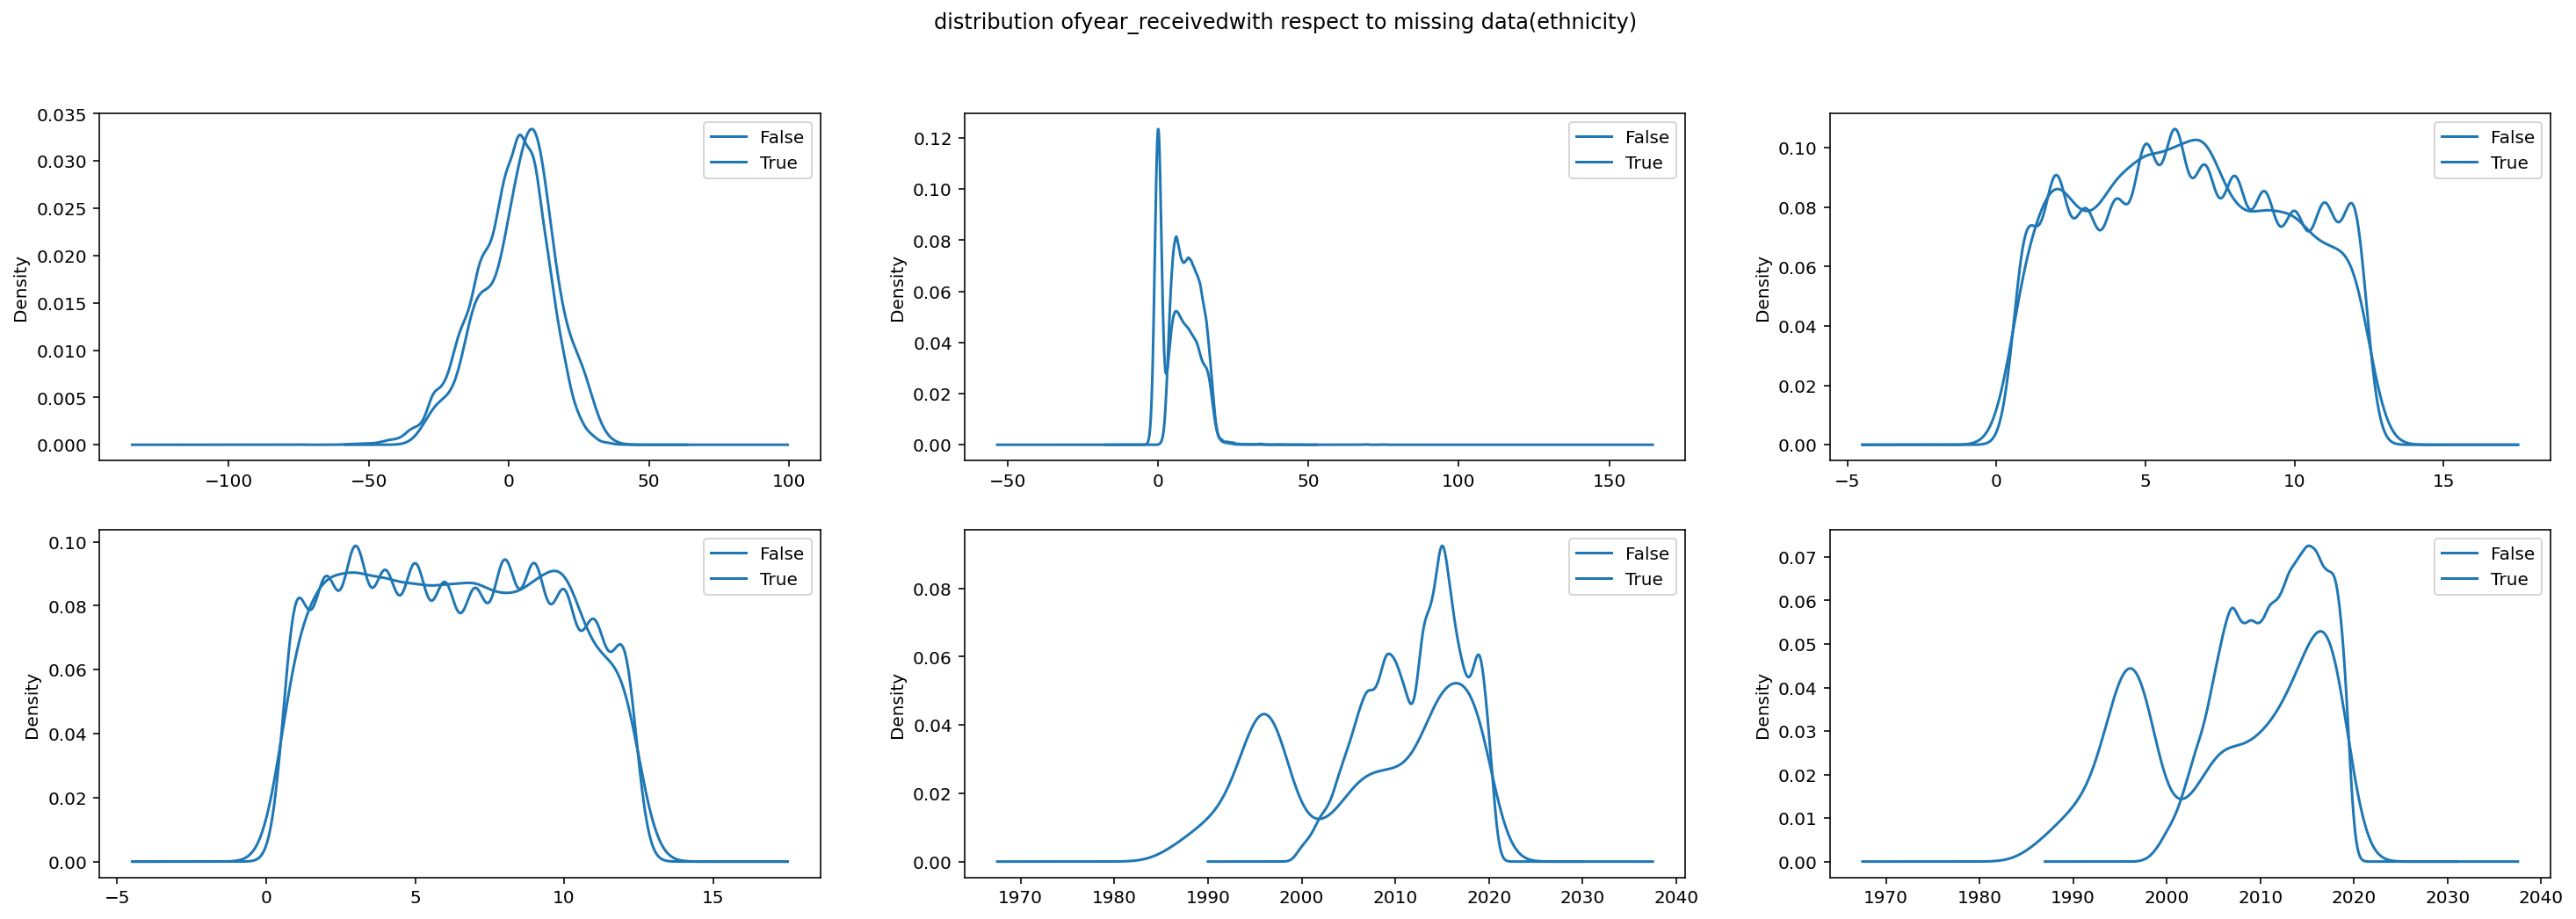

In [245]:
# TODO
#helper methods
def ks(data, col, group_col):
    """tvd of the distribution of values in col
    bewteen the two groups of group_col. col is
    assumed to be categorical."""
    from scipy.stats import ks_2samp
    valA, valB = data[group_col].unique()
    ks, _ = ks_2samp(
        data.loc[data[group_col] == valA, col],
        data.loc[data[group_col] == valB, col]
    )
    return ks
def diff_in_means(data, col, group_col):
    return data.groupby(group_col)[col].mean().diff().iloc[-1]

def permutation_test(data, col, group_col, test_statistic=ks, N=100):
    obs = test_statistic(data, col, group_col)
    shuffled_stats = []
    for _ in range(N):
        shuffled = data[group_col].sample(
            frac=1, replace=False).reset_index(drop=True)
        with_shuffled = data[[col]].assign(shuffled=shuffled)
        shuffled_stat = test_statistic(with_shuffled, col, 'shuffled')
        shuffled_stats.append(shuffled_stat)
    shuffled_stats = np.array(shuffled_stats)
    
    return shuffled_stats, obs
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(25,8))
i=0
for curr_col in ["age_diff", "duration", "month_closed", "month_received", "year_closed", "year_received"]:
    dist,obs= permutation_test(data=allegations.assign(is_null=allegations["complainant_ethnicity"].isnull()), col=curr_col, group_col="is_null", test_statistic=ks, N=500)
    print((dist>=obs).mean())
    temp=allegations.assign(is_null=allegations["complainant_ethnicity"].isnull())
    temp.groupby('is_null')[curr_col].plot(kind='kde', legend=True,title="distribution of"+curr_col+"with respect to missing data(ethnicity)", subplots=True,ax=axes[i//3,i%3]);
    
    i+=1



(I tried plotting with titles, but it doesn't work as intended for the 6 plots, so I will describe here. The top three plots correspond to distribution of age_diff, duration, month closed(left to right), and the bottom three plots correspond to distribution of month_received, year_closed, year_received).
From the result shown, the missingess of conplainant_ethnicity is dependent on the age_diff betweeen officer and complainant, as the KS stats with permutation testing yields p-value of 0.0 for 500 trials, showin that the distributions are different in age_diff when grouped by missingness of complainant ethnicity. In other words, complainant ethnicity is MAR on age_diff.

This idea also applies on other columns as well. When looking at the p_values, we could infer, with the use of KS Stats, that missingness of complainant_ethnicity is MAR on age_diff, duration, month_closed, year_closed, year_received, while not MAR on month_received,as under signficance level of 0.01, the null hypothesis,stating that the two groups(by missingness) comes from the same distribution, isn't rejected.

### Hypothesis Test

In [320]:
def tvd(data, col, group_col):
    tvd = (
        data
        .pivot_table(
            index=col,
            columns=group_col,
            aggfunc='size',
            fill_value=0
        )
        .apply(lambda x: x / x.sum())
        .diff(axis=1).iloc[:, -1].abs().sum() / 2
    )
    return tvd

allegations["sub_ratio"]=(allegations["result"]=="Substantiated")
obs_df=allegations.groupby("complainant_ethnicity")["sub_ratio"].mean()
total_mean=allegations["sub_ratio"].mean()
obs = abs(temp-total_mean).sum()/2
shuffled_stats = []
for i in range(500):
    shuffled = allegations["sub_ratio"].sample(frac=1, replace=False).reset_index(drop=True)
    with_shuffled = allegations[["complainant_ethnicity"]].assign(shuffled=shuffled)
    grouped_df=with_shuffled.groupby("complainant_ethnicity")["shuffled"].mean()
    shuffled_stat = abs(grouped_df-total_mean).sum()/2
    shuffled_stats.append(shuffled_stat)
shuffled_stats=np.array(shuffled_stats)
print((shuffled_stats>=obs).mean())


0.0


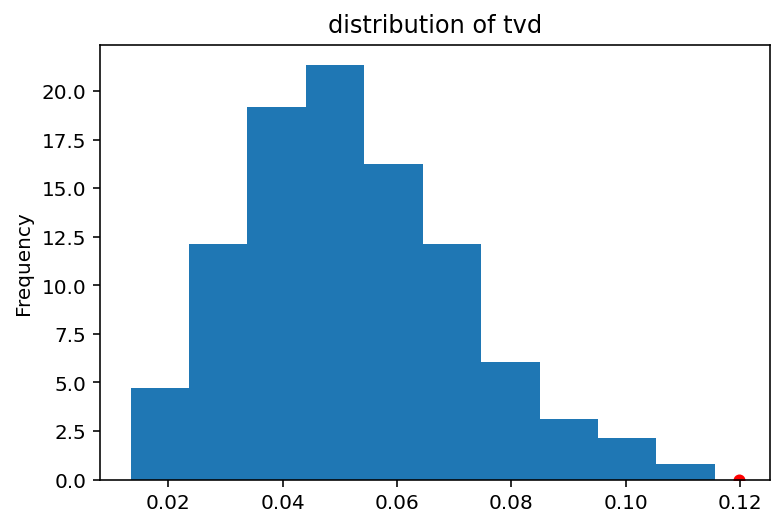

In [322]:
pd.Series(shuffled_stats).plot(kind='hist', density=True, title='distribution of tvd')
plt.scatter([obs], [0], s=25, c='r');


The null hypothesis states that the substantiated ratio between complainant ethnicities should be approximately the same, while the alternative hypothesis states that the substantiated ratio between complainant ethnicities are different. A significance level of 0.01 is chosen,while TVD stats is chosen. We are assuming that if null hypothesis is true, then the substantiated ratio should be the same across ethnicities, which should then also be close to the true substanstiated mean 0.245(calculated in variable total_mean). Whenever we shuffle, we recalculate the grouped means, and subtract it the the true means, and then calculate tvd. We then figure out that the p-value is 0.0 under 500 trials, indicating that the substantiated ratio across complainant_ethnicity are different, as we reject the null hypothesis